# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [2]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### 1) Importer le tableau de données dans un dataframe 

In [3]:
# Import du dataframe "data.csv"
df = pd.read_csv("data.csv", decimal=",")

*L'argument `decimal=","` remplace le point par la virgule.*

In [4]:
# Print the first ten rows
df.head(10)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux
5,S&P Global Ratings,Lead data scientist,VBA/Python/Excel/R,Master,6.0,Lille
6,NVIDIA,Data scientist,Excel/VBA/R/Python/PySpark,Bachelor,0.0,Lille
7,Cedars-Sinai Medical Center,Data scientist,Java/C/C++/R/Python,Bachelor,4.0,Toulouse
8,Fibroblast,Data architecte,Java/Linux/Docker,Bachelor,8.0,Paris
9,General Motors,Data engineer,Python/Java/Linux/GNU,Master,5.0,Toulouse


In [5]:
# description of numeric columns, ie Experience
df.describe() 

,Experience
count,9488.000000
mean,2.814186
std,2.716293
min,0.000000
25%,1.000000
50%,2.000000
75%,3.500000
max,21.000000


In [6]:
# Main informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
Entreprise      9565 non-null object
Metier          9563 non-null object
Technologies    9582 non-null object
Diplome         9582 non-null object
Experience      9488 non-null float64
Ville           9582 non-null object
dtypes: float64(1), object(5)
memory usage: 449.3+ KB


Remarques:  
   * Dimensions 9582 
   * La variable "Experience " est l'unique variable nimérique

### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

**Nombre d'observations**

In [7]:
print(f'Ce dataframe contient {df.shape[0]} observations.')

Ce dataframe contient 9582 observations.


**Analyse des données manquantes**

In [34]:
# Le nombre de valeurs manquantes par colonnes
print(df.isnull().sum())

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64


Les varaibles qui contiennent les valeurs manquantes sont:
- Entreprise 
- Metier 
- Experience

In [9]:
# nombre total de valeurs manquantes 
print(f'Ce dataframe contient au total {df.isnull().sum().sum()} valeurs manquantes')

Ce dataframe contient au total 130 valeurs manquantes


**Remarques:**
* Nombre de valeurs manquantes par colonnes:

In [56]:
df.isnull().sum(axis = 0)

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      42
Ville            0
dtype: int64

* Nombre de valeurs manquantes restantes pour la variable expérience:

In [59]:
Nbre_na_da = df["Experience"][df["Metier"] == 'Data architecte'].isna().sum()
print(f'Nombre de valeurs manquantes pour les Data architectes {Nbre_na_da}.')

Nbre_na_lds = df["Experience"][df["Metier"] == 'Lead data scientist'].isna().sum()
print(f'Nombre de valeurs manquantes pour les Lead data scientists {Nbre_na_lds}.')

Nombre de valeurs manquantes pour les Data architectes 23
Nombre de valeurs manquantes pour les Lead data scientists 19


Nous avons au total 42 valeurs manquantes
- Data architecte:  23
- Lead data scientist: 19

Pour traiter ces valeurs manquantes on peut les imputer par la valeur moyenne de la variable expérience par cathegorie, ou par la médiane. Il est égalment possible de les prédire par des techniques similaires à celles proposées dans la question 9. 


### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

#### a) Nombre de valeurs manquentes pour les data scientists et les data engineers

In [36]:
Nbre_na_ds = df["Experience"][df["Metier"] == 'Data scientist'].isna().sum()
print(f'Nombre de valeurs manquantes pour les data scientists {Nbre_na_ds}.')

Nombre de valeurs manquantes pour les data scientists 32


In [37]:
Nbre_na_de = df["Experience"][df["Metier"] == 'Data engineer'].isna().sum()
print(f'Nombre de valeurs manquantes pour les data engineers {Nbre_na_de}.')

Nombre de valeurs manquantes pour les data engineers 20


#### b) Calcul de la mediane des années d'experience des data scientists et la moyenne d'experience des data engineers

In [11]:
Exp_ds = df['Experience'][df['Metier'] == 'Data scientist']
Med_exp_ds = Exp_ds.median(axis=0, skipna=True)
print(f"Le nombre d'années d'expérience médian pour les data scientist est de {Med_exp_ds}.")

Le nombre d'années d'expérience médian pour les data scientist est de 2.0.


In [24]:
Exp_de = df['Experience'][df['Metier'] == 'Data engineer']
Mean_exp_de = Exp_de.mean(axis=0, skipna=True)
print("Les data engineers ont en moyenne {:.2f} d'années d'experience.".format(Mean_exp_de))

Les data engineers ont en moyenne 2.98 d'années d'experience.


#### c) Imputation des valeurs manquantes pour la variable "Experience"

In [25]:
# According to the median for the data scientists
Index_missing_values_ds = list(df[df['Metier'] == 'Data scientist'].loc[df['Experience'].isnull(),'Experience'].index)
df.iloc[Index_missing_values_ds , 4] = Med_exp_ds

In [26]:
# According to the median for the data engineers
Index_missing_values_de = list(df[df['Metier'] == 'Data engineer'].loc[df['Experience'].isnull(),'Experience'].index)
df.iloc[Index_missing_values_de, 4] = Mean_exp_de

#### d) Affichage des modifications apportées

In [28]:
df.describe()

,Experience
count,9540.000000
mean,2.811803
std,2.709299
min,0.000000
25%,1.000000
50%,2.000000
75%,3.500000
max,21.000000


### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

#### a) Nombres d'observation par profil

In [43]:
# Number of obsertion by job type 
df.groupby(by='Metier').size()

Metier
Data architecte        2123
Data engineer          2347
Data scientist         3865
Lead data scientist    1228
dtype: int64

#### b) Calcul de la moyenne d'experience pour chaque profil

In [44]:
print(round(df.groupby('Metier').mean(),2))

                     Experience
Metier                         
Data architecte            3.00
Data engineer              3.13
Data scientist             2.24
Lead data scientist        3.97


* En moyenne les Lead data scientists ont plus d'année d'experience que les autres profils.
* En revanche les profils data scientists sont ceux qui ont en moyenne peu d'année d'experience.

### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

Text(0.5, 1.0, "Représentation du nombre d'année d'expérience par métier")

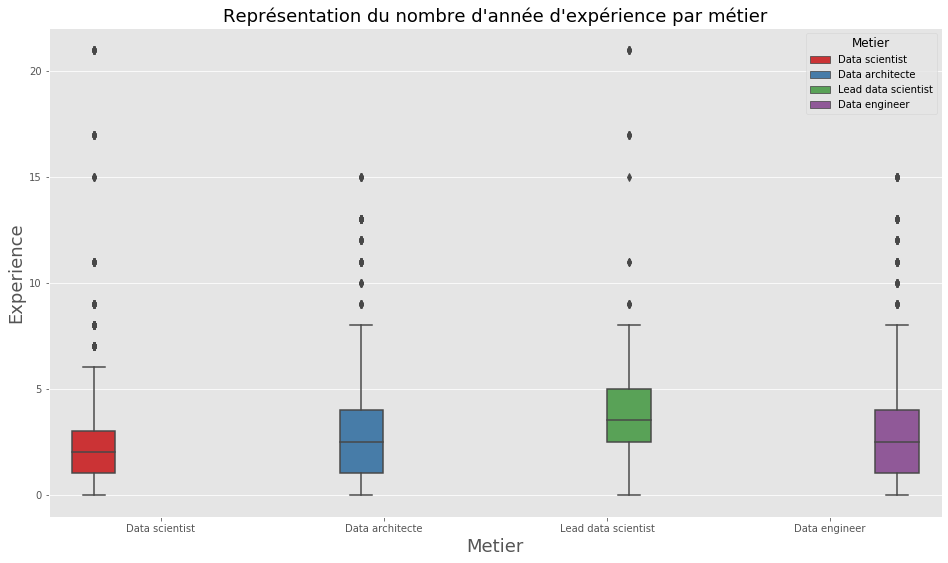

In [29]:
plt.figure(figsize=(16, 9))
b =  sb.boxplot(x="Metier", y="Experience",
            hue="Metier", data=df, palette="Set1")
b.axes.set_xlabel("Metier",fontsize=18)
b.axes.set_ylabel("Experience",fontsize=18)
b.axes.set_title("Représentation du nombre d'année d'expérience par métier",fontsize=18)

In [46]:
print(round(df.groupby('Metier').var(),2))

                     Experience
Metier                         
Data architecte            7.42
Data engineer             10.10
Data scientist             6.33
Lead data scientist        7.26


In [47]:
print(round(df.groupby('Metier').median(),2))

                     Experience
Metier                         
Data architecte             2.5
Data engineer               2.5
Data scientist              2.0
Lead data scientist         3.5


Ce box-plot permet de visualiser les concepts tels que la symétrie, la dispersion ou la centralité des distributions des valeurs associées à la variable `Expérience`. 

Remarque: **Les 4 classes contiennent des valeurs extremes (outliers)**

**ANOVA: Test de comparaison des moyennes**

In [33]:
from sklearn.feature_selection import f_classif

**Creation of a data frame:**

In [42]:
Annova_df = pd.DataFrame(df['Experience']) 
Annova_df["Metier"] = df['Metier']
Annova_df.dropna(inplace = True) # Delete all rows with one or two NA

In [72]:
X =  np.array(Annova_df['Experience']).reshape(-1, 1)
y = Annova_df['Metier'].astype('category').cat.codes

Annova_res = f_classif(X, y)
print(f'The F-Score is equal to {round(float(Annova_res[0]), 2)}, associating to a p-value of {float(Annova_res[1]):.2e}.')

The F-Score is equal to 143.09, associating to a p-value of 1.08e-90.


**Interprétation:** Le nombre moyen d'années d'expérience par profession est statistiquement différent.

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

#### a) Imputation des données manquantes de la variable expérience:

*Rappel:*

In [60]:
Nbre_na_da = df["Experience"][df["Metier"] == 'Data architecte'].isna().sum()
print(f'Nombre de valeurs manquantes pour les Data architectes {Nbre_na_da}.')

Nbre_na_lds = df["Experience"][df["Metier"] == 'Lead data scientist'].isna().sum()
print(f'Nombre de valeurs manquantes pour les Lead data scientists {Nbre_na_lds}.')

Nombre de valeurs manquantes pour les Data architectes 23.
Nombre de valeurs manquantes pour les Lead data scientists 19.


**Calcul des moyennes d'experience pour les profession:**
- Data architecte 
- Lead data scientist

In [52]:
Exp_da = df['Experience'][df['Metier'] == 'Data architecte']
Mean_exp_da = Exp_da.mean(axis=0, skipna=True)

In [53]:
Exp_lds = df['Experience'][df['Metier'] == 'Lead data scientist']
Mean_exp_lds = Exp_lds.mean(axis=0, skipna=True)

**Imputation des valeurs manquants par la moyenne par professsion**

In [54]:
Index_missing_values_da = list(df[df['Metier'] == 'Data architecte'].loc[df['Experience'].isnull(),'Experience'].index)
df.iloc[Index_missing_values_da, 4] =  Mean_exp_da

In [55]:
Index_missing_values_lds  = list(df[df['Metier'] == 'Lead data scientist'].loc[df['Experience'].isnull(),'Experience'].index)
df.iloc[Index_missing_values_lds, 4] =  Mean_exp_lds

#### b) Transformation des données manquantes de la variable Metier par 'Unknown'

In [61]:
print(f"Nombre de valeurs manquantes pour la variable Metier: {df['Metier'].isna().sum()}.")

Nombre de valeurs manquantes pour la variable Metier: 19.


In [62]:
df['Metier'] = df['Metier'].fillna('Unknown')

#### c) Création d'une variable catégorielle pour expérience

**Spécification de la stratégie:**

Les quantiles pour chaque profession définissent les labels d'expérience tels que:
* If Exp < quantile(0.25) => Exp_label = Débutant
* Elif Exp in [quantile(0.25), quantile(0.5)) = Confirmé
* Elif Exp in [quantile(0.5), quantile(0.75)) = Avancé
* Else Exp >= quantile(0.75) = Expert


In [81]:
print(f"""Cette stratégie permet de prendre en compte les spécificités d'évolution de chaque profession. 
Ainsi un Lead data scientist est considéré comme confirmé après {df['Experience'][df['Metier'] =='Lead data scientist'].quantile(q=0.25)} 
années d'expérience tandis qu'un data scientist après seulement {df['Experience'][df['Metier'] =='Data scientist'].quantile(q=0.25)} année.""")

Cette stratégie permet de prendre en compte les spécificités d'évolution de chaque profession. 
Ainsi un Lead data scientist est considéré comme confirmé après 2.5 
années d'expérience tandis qu'un data scientist après seulement 1.0 année.


**Création d'une colonne vide `Exp_label`:**

In [57]:
df['Exp_label'] = np.nan

In [58]:
Metier_l = list(set(df['Metier'])) # Set of Metier => 4 elements
quantile_label = {0.25:'debutant', 0.5:'confirme', 0.75:'avance', 0.76:'expert'} # Dictionary
for i in Metier_l:
    for ql in quantile_label:
        if ql <= 0.75: # No expert
            ind = list(df[(df['Metier'] == i) & (df['Exp_label'].isna())].loc[df['Experience'] < df['Experience'].quantile(q=ql),'Experience'].index)
            df.iloc[ind , 6] = quantile_label[ql]
        else: # Expert 
            ind = list(df[(df['Metier'] == i) & (df['Exp_label'].isna())].index)
            df.iloc[ind , 6] = quantile_label[ql]

#### e) Representation graphique du niveau d'expérience par profession

Text(0.5,1,"Répartion des niveaux d'expériece par métier")

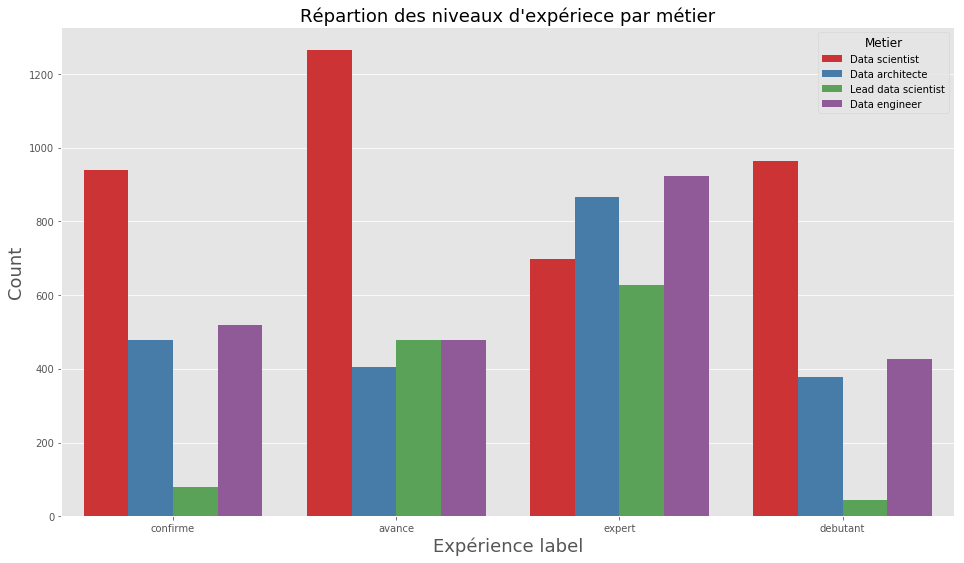

In [59]:
plt.figure(figsize=(16, 9))
b =  sb.countplot( x="Exp_label", hue="Metier", data=df, palette="Set1")

b.axes.set_xlabel("Expérience label",fontsize=18)
b.axes.set_ylabel("Count",fontsize=18)
b.axes.set_title("Répartion des niveaux d'expériece par métier",fontsize=18)

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [60]:
l =[]
techno = df['Technologies']
for i in range(len(techno)):
    v = re.split('/', techno[i], flags=re.IGNORECASE)
    for i in range(len(v)):
        l.append(v[i])

# transformation des données
data_technologie = pd.Series(l).value_counts()
data_techno = data_technologie.to_frame().reset_index()
data_techno.columns = ['technologie', 'frequence']

data_techno.head()


,technologie,frequence
0,Python,6627
1,R,4374
2,SQL,2581
3,Java,1719
4,Hadoop,1589


In [61]:
# extraction des 5 technologie les plus utilisées
top5 = data_techno.iloc[0:5]
print(top5)

  technologie  frequence
0      Python       6627
1           R       4374
2         SQL       2581
3        Java       1719
4      Hadoop       1589


Text(0.5,1,'Top 5 des tecnhologies')

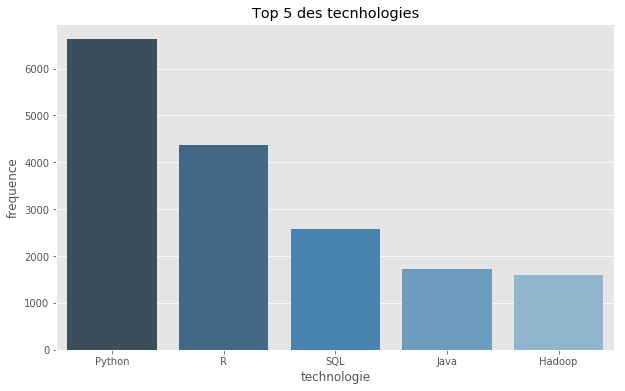

In [62]:
plt.figure(figsize=(10,6))
sb.barplot('technologie', 'frequence', data=top5, palette="Blues_d").set_title("Top 5 des tecnhologies")

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

#### a) Encodage des variables


In [126]:
# entreprise 
s = pd.Series(list(df['Entreprise']))
one_hot_encoding_entreprise = pd.get_dummies(s)
one_hot_encoding_entreprise.shape
indexL = []
one_hot_encoding_entreprise.sum(axis=1)
for i in range(one_hot_encoding_entreprise.shape[1]):
    if one_hot_encoding_entreprise.iloc[:,i].sum() < 30:
        indexL.append(i)
one_hot_encoding_entreprise = one_hot_encoding_entreprise.drop(one_hot_encoding_entreprise.columns[indexL], axis=1)

In [127]:
print(one_hot_encoding_entreprise.shape)

(9582, 49)


In [128]:
# technologie

Ltechno = []
techno = df['Technologies']
for i in range(len(techno)):
    v = re.split('/', techno[i], flags=re.IGNORECASE)
    for i in range(len(v)):
        Ltechno.append(v[i])
set_Techno = list(set(Ltechno))
set_Techno = set_Techno[1:len(set_Techno)] # Remove the empty techno

MTechno = np.zeros((df.shape[0], len(set_Techno)))
dfTechno = pd.DataFrame(MTechno)


In [129]:
for i in range(len(set_Techno)):
    for j in range(df.shape[0]):
        if df['Technologies'][j].find(set_Techno[i]) != -1:
            dfTechno.iloc[j,i] = 1

In [143]:
dfTechno.shape

(9582, 60)

In [638]:
# Diplome 
s_techno = pd.Series(list(df['Technologies']))
one_hot_encoding_techno = pd.get_dummies(s_techno)

In [653]:
print(one_hot_encoding_techno.shape)

(9582, 57)


In [654]:
# metier 
s_metier = pd.Series(list(df['Metier']))
one_hot_encoding_metier = pd.get_dummies(s_metier)

In [655]:
print(one_hot_encoding_metier.shape)

(9582, 4)


In [656]:
# Diplome 
s_diplome = pd.Series(list(df['Diplome']))
one_hot_encoding_diplome = pd.get_dummies(s_diplome)

In [657]:
print(one_hot_encoding_experience.sum(axis=0))
print(one_hot_encoding_diplome.shape)


avance      2625
confirme    2015
debutant    1811
expert      3112
dtype: int64
(9582, 4)


In [658]:
# Exp_label 
s_experience = pd.Series(list(df['Exp_label']))
one_hot_encoding_experience = pd.get_dummies(s_experience)

In [659]:
print(one_hot_encoding_experience.shape)
print(one_hot_encoding_experience.sum(axis=0))

(9582, 4)
avance      2625
confirme    2015
debutant    1811
expert      3112
dtype: int64


In [660]:
# Ville
s_ville = pd.Series(list(df['Ville']))
one_hot_encoding_ville = pd.get_dummies(s_ville)

In [661]:
print(one_hot_encoding_ville.sum(axis=0))
print(one_hot_encoding_ville.shape)

Bordeaux        692
Grenoble         99
Lille           771
Lyon           1781
Marseille      1548
Montpellier      87
Nantes          365
Nice            183
Paris          2015
Rennes          360
Rouen           315
Strasbourg      309
Toulon          186
Toulouse        871
dtype: int64
(9582, 14)


#### b) Merge des data frames

In [669]:
# merge all data transform
df_merge = pd.concat([one_hot_encoding_diplome, 
                      one_hot_encoding_entreprise, 
                      one_hot_encoding_techno,
                      one_hot_encoding_metier,
                      one_hot_encoding_ville , 
                      one_hot_encoding_experience], axis=1)


In [670]:
print(f'le nouveau daframe contient {df_merge.shape[0]} observation et {df_merge.shape[1]} variables')
print(f'Le daframe initial contient {df.shape[0]} observation et {df.shape[1]-1} variables')

le nouveau daframe contient 9582 observation et 132 variables
Le daframe initial contient 9582 observation et 6 variables


In [671]:
df_merge.head()

,Bachelor,Master,No diploma,Phd,Accenture,"Advanced Micro Devices, Inc.",Allstate,Amazon.com,Ball Aerospace,Bank of America,...,Paris,Rennes,Rouen,Strasbourg,Toulon,Toulouse,avance,confirme,debutant,expert
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### C) Selection des variables

In [672]:
# sampling data in train and test
X = df_merge.iloc[ :, :df_merge.shape[1]-1]
y = df_merge.iloc[:,-1]


In [673]:
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

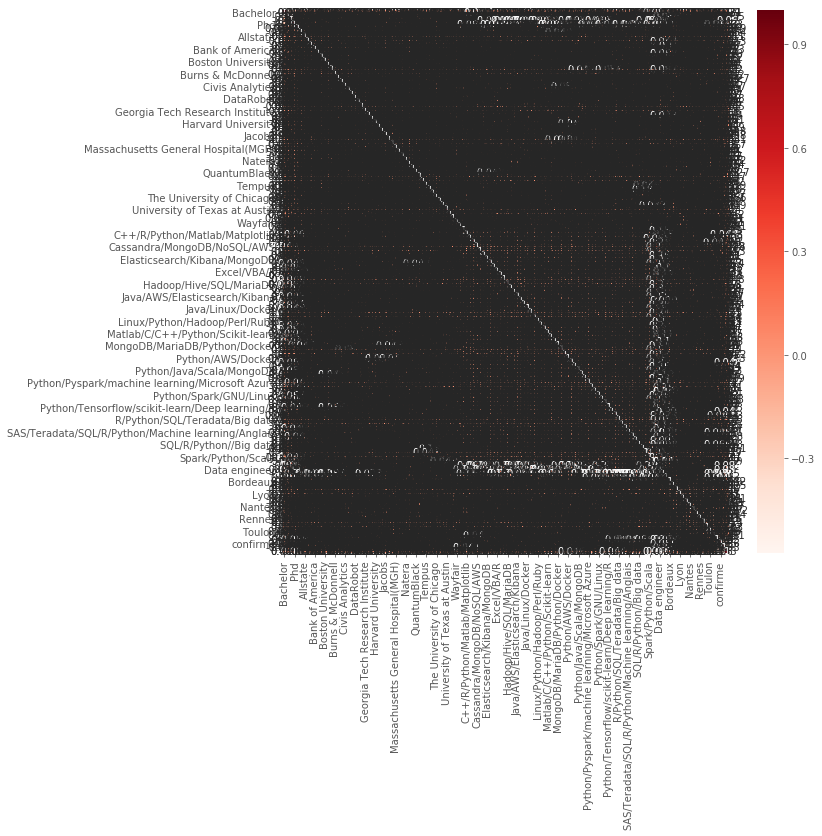

In [676]:
#Using Pearson Correlation
plt.figure(figsize=(10,10))
cor = df_merge.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [678]:
#Correlation with output variable
cor_target = abs(cor["expert"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

No diploma             0.060013
Phd                    0.062668
Data architecte        0.094178
Data engineer          0.082785
Data scientist         0.253606
Lead data scientist    0.152794
avance                 0.426011
confirme               0.357885
debutant               0.334802
expert                 1.000000
Name: expert, dtype: float64

In [679]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

/Users/auelien/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha using built-in LassoCV: 0.000089
Best score using built-in LassoCV: 0.999685


In [680]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " 
      +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 124 variables


Text(0.5,1,'Feature importance using Lasso Model')

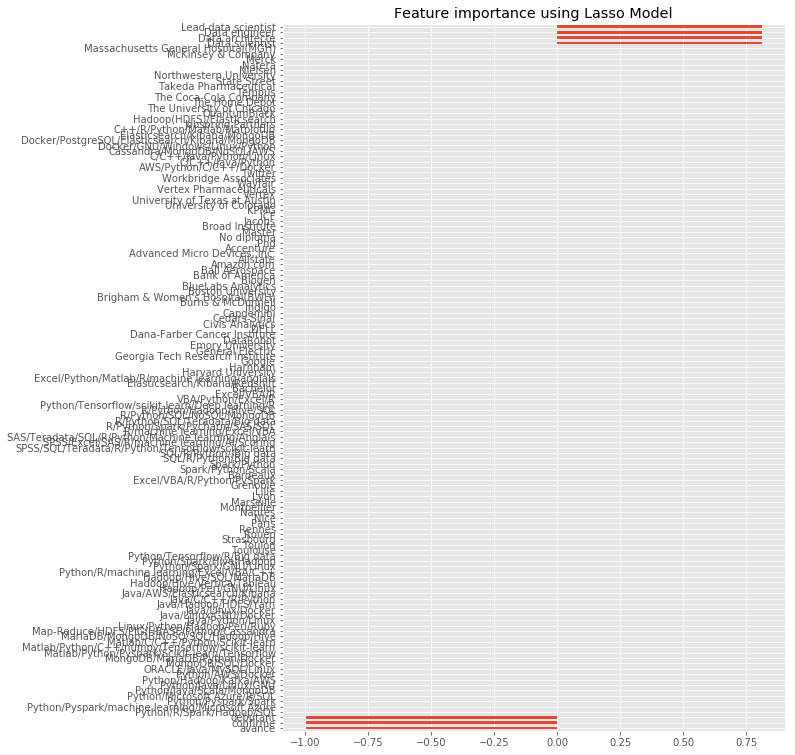

In [683]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (9.0, 13.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [531]:
#classe pour l'ACP
from sklearn.decomposition import PCA
#instanciation
acp = PCA(svd_solver='full')

In [532]:
print(acp)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)


In [534]:
#calculs
coord = acp.fit_transform(df_merge)
#nombre de composantes calculées
print(acp.n_components_)

75


In [535]:
#variance expliquée
print(acp.explained_variance_)

[7.05309930e-01 3.65147088e-01 2.96176406e-01 2.38332251e-01
 2.24069211e-01 2.01627680e-01 1.96395294e-01 1.71797604e-01
 1.19569724e-01 8.58587762e-02 7.55487385e-02 7.18468412e-02
 4.95001045e-02 3.78514739e-02 3.47082866e-02 3.25283970e-02
 2.16326650e-02 1.93072768e-02 1.36331110e-02 1.30983055e-02
 1.19060808e-02 1.15973608e-02 1.12846925e-02 1.10518441e-02
 9.51496377e-03 9.45418377e-03 8.68074607e-03 8.56335421e-03
 8.23635534e-03 7.04654026e-03 6.85719210e-03 6.82937140e-03
 6.72902984e-03 6.56302957e-03 6.51883982e-03 6.42418176e-03
 6.31991416e-03 6.25539224e-03 6.24810281e-03 6.24005741e-03
 5.94114891e-03 5.38415133e-03 5.10859959e-03 5.10395893e-03
 5.05066692e-03 4.99879523e-03 4.99778324e-03 4.83997322e-03
 4.63136456e-03 4.47856156e-03 4.39300390e-03 4.13253509e-03
 3.84329872e-03 3.75301003e-03 3.74954757e-03 3.69522688e-03
 3.61877455e-03 3.51282574e-03 3.33173664e-03 3.32973200e-03
 3.30144871e-03 3.23154808e-03 3.22832832e-03 3.22353251e-03
 3.17154420e-03 3.125012

In [542]:
# valeur corrigée
n = df_merge.shape[0]
eigval = (n-1)/n*acp.explained_variance_ 
print(eigval)

[7.05236322e-01 3.65108981e-01 2.96145496e-01 2.38307378e-01
 2.24045827e-01 2.01606638e-01 1.96374798e-01 1.71779675e-01
 1.19557246e-01 8.58498158e-02 7.55408541e-02 7.18393431e-02
 4.94949385e-02 3.78475237e-02 3.47046644e-02 3.25250023e-02
 2.16304073e-02 1.93052618e-02 1.36316882e-02 1.30969385e-02
 1.19048383e-02 1.15961504e-02 1.12835148e-02 1.10506907e-02
 9.51397076e-03 9.45319710e-03 8.67984013e-03 8.56246052e-03
 8.23549578e-03 7.04580487e-03 6.85647647e-03 6.82865867e-03
 6.72832758e-03 6.56234464e-03 6.51815949e-03 6.42351132e-03
 6.31925460e-03 6.25473941e-03 6.24745074e-03 6.23940618e-03
 5.94052887e-03 5.38358943e-03 5.10806645e-03 5.10342627e-03
 5.05013982e-03 4.99827354e-03 4.99726166e-03 4.83946811e-03
 4.63088122e-03 4.47809417e-03 4.39254543e-03 4.13210381e-03
 3.84289762e-03 3.75261835e-03 3.74915626e-03 3.69484124e-03
 3.61839688e-03 3.51245913e-03 3.33138894e-03 3.32938450e-03
 3.30110416e-03 3.23121083e-03 3.22799140e-03 3.22319610e-03
 3.17121321e-03 3.124685

In [543]:
print(acp.singular_values_**2/n)

[7.05236322e-01 3.65108981e-01 2.96145496e-01 2.38307378e-01
 2.24045827e-01 2.01606638e-01 1.96374798e-01 1.71779675e-01
 1.19557246e-01 8.58498158e-02 7.55408541e-02 7.18393431e-02
 4.94949385e-02 3.78475237e-02 3.47046644e-02 3.25250023e-02
 2.16304073e-02 1.93052618e-02 1.36316882e-02 1.30969385e-02
 1.19048383e-02 1.15961504e-02 1.12835148e-02 1.10506907e-02
 9.51397076e-03 9.45319710e-03 8.67984013e-03 8.56246052e-03
 8.23549578e-03 7.04580487e-03 6.85647647e-03 6.82865867e-03
 6.72832758e-03 6.56234464e-03 6.51815949e-03 6.42351132e-03
 6.31925460e-03 6.25473941e-03 6.24745074e-03 6.23940618e-03
 5.94052887e-03 5.38358943e-03 5.10806645e-03 5.10342627e-03
 5.05013982e-03 4.99827354e-03 4.99726166e-03 4.83946811e-03
 4.63088122e-03 4.47809417e-03 4.39254543e-03 4.13210381e-03
 3.84289762e-03 3.75261835e-03 3.74915626e-03 3.69484124e-03
 3.61839688e-03 3.51245913e-03 3.33138894e-03 3.32938450e-03
 3.30110416e-03 3.23121083e-03 3.22799140e-03 3.22319610e-03
 3.17121321e-03 3.124685

In [556]:
print(acp.components_)

p = df_merge.shape[1]

[[ 1.29816411e-01 -5.79364396e-01  7.32413892e-02 ...  2.28112299e-03
  -2.54160975e-03 -2.00529503e-02]
 [ 4.49254368e-01 -1.70113815e-01  1.55511267e-01 ... -2.79961501e-02
  -3.22856785e-02  2.62706597e-01]
 [ 2.23441195e-01 -2.42480338e-02 -6.29951560e-02 ...  1.33511311e-01
   9.43260121e-02 -7.46544959e-01]
 ...
 [-0.00000000e+00  2.96059223e-01  3.25723957e-01 ...  5.63785130e-18
   3.46944695e-18 -6.93889390e-18]
 [-0.00000000e+00 -2.00933005e-02 -9.76241746e-04 ...  3.82723367e-17
   5.11201324e-17  7.37257477e-17]
 [ 0.00000000e+00  2.38473895e-01 -5.00232889e-01 ... -8.02309608e-18
   1.56125113e-17 -6.93889390e-18]]


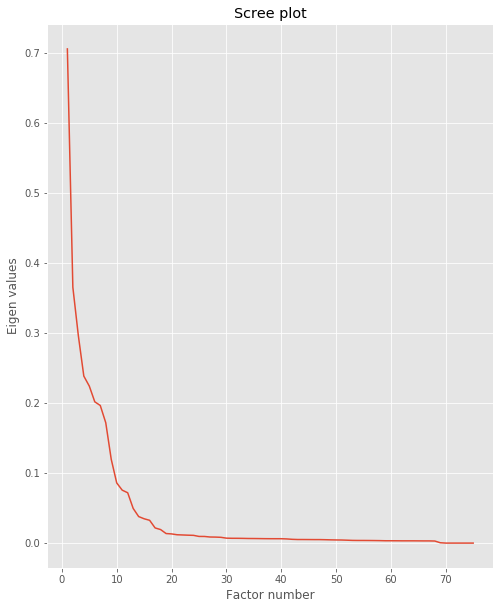

In [557]:
#scree plot
plt.plot(np.arange(1,p+1),eigval) 
plt.title("Scree plot ACP ") 
plt.ylabel("Eigen values") 
plt.xlabel("Factor number") 
plt.show()

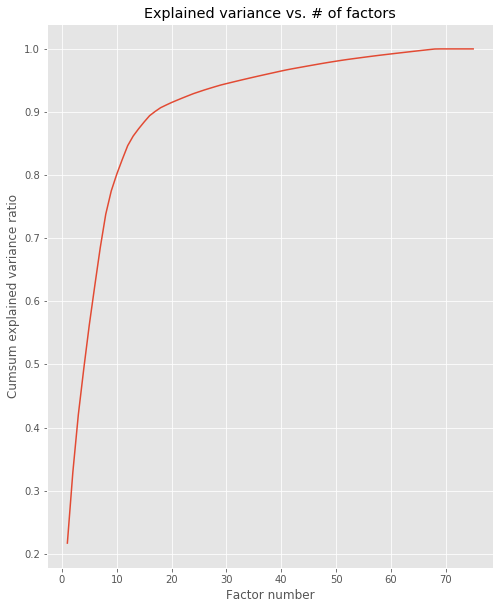

In [562]:
plt.plot(np.arange(1,p+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

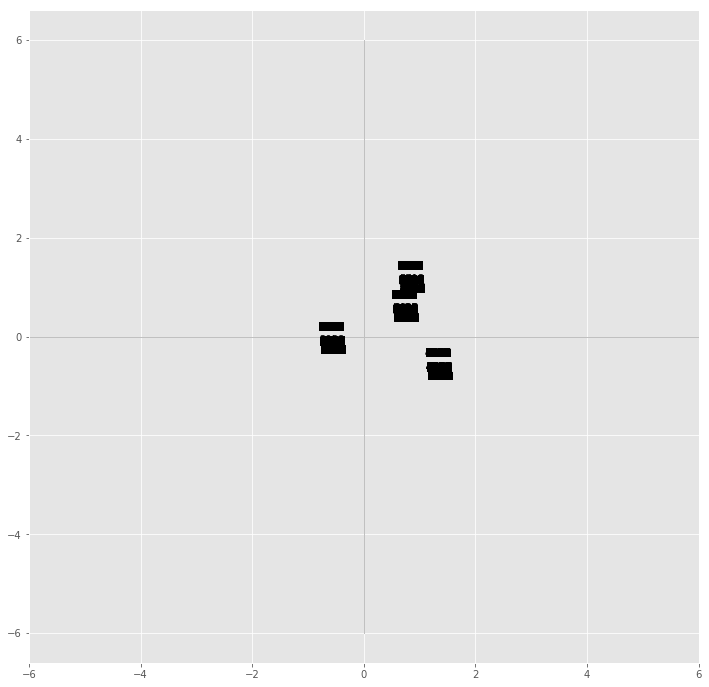

In [566]:

fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6) #même limites en abscisse axes.set_ylim(-6,6) #et en ordonnée
#placement des étiquettes des observations
for i in range(n): 
    plt.annotate(X.index[i],(coord[i,0],coord[i,1]))
    
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1) 
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
#affichage
plt.show()

In [599]:
print(np.shape(acp.components_))

(75, 75)


In [573]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(acp.components_)
print(PCA_components)

          0         1         2         3             4             5   \
0   0.129816 -0.579364  0.073241  0.376307 -1.381819e-03 -5.191971e-04   
1   0.449254 -0.170114  0.155511 -0.434652  4.347256e-04 -4.740698e-04   
2   0.223441 -0.024248 -0.062995 -0.136198  5.223507e-04  2.872019e-04   
3  -0.015098 -0.001159  0.005638  0.010618  2.353583e-04  7.952104e-04   
4  -0.325280 -0.098155  0.583237 -0.159802 -3.154501e-04 -5.434019e-04   
..       ...       ...       ...       ...           ...           ...   
70  0.000000 -0.054880  0.442481  0.551367 -2.493665e-17  8.553135e-16   
71  0.702369 -0.168140  0.040036 -0.005002  4.163336e-16  5.377643e-16   
72 -0.000000  0.296059  0.325724 -0.410665  3.525012e-17  9.961107e-17   
73 -0.000000 -0.020093 -0.000976 -0.039754 -9.856075e-17  1.310699e-16   
74  0.000000  0.238474 -0.500233  0.159118 -1.035413e-17 -1.344953e-16   

              6             7             8             9   ...        65  \
0   3.481667e-04 -1.104603e-03 -2.

([<matplotlib.axis.XTick at 0x1a2d870b90>,
 <a list of 75 Text xticklabel objects>)

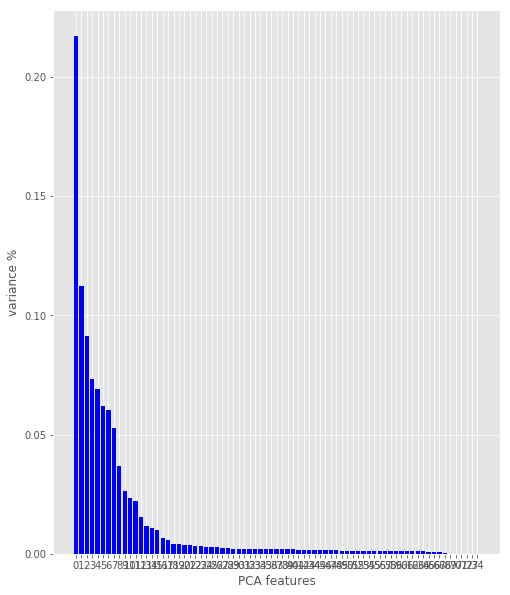

In [578]:
features = range(acp.n_components_)
plt.bar(features, acp.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

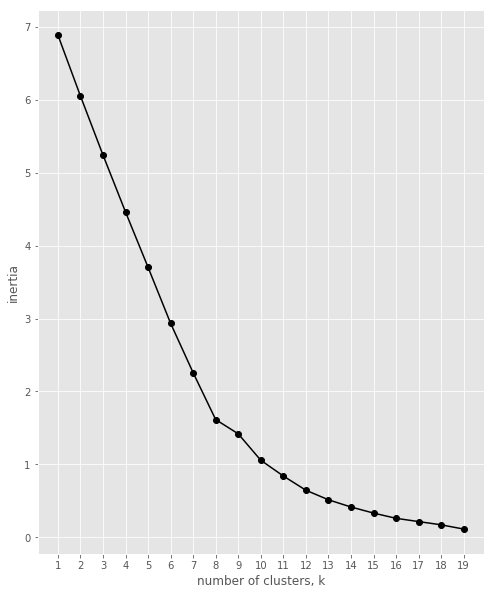

In [587]:
from sklearn.cluster import KMeans


ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:7])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [593]:
print(PCA_components.iloc[:,:7])

           0         1         2         3             4             5  \
0   0.129816 -0.579364  0.073241  0.376307 -1.381819e-03 -5.191971e-04   
1   0.449254 -0.170114  0.155511 -0.434652  4.347256e-04 -4.740698e-04   
2   0.223441 -0.024248 -0.062995 -0.136198  5.223507e-04  2.872019e-04   
3  -0.015098 -0.001159  0.005638  0.010618  2.353583e-04  7.952104e-04   
4  -0.325280 -0.098155  0.583237 -0.159802 -3.154501e-04 -5.434019e-04   
..       ...       ...       ...       ...           ...           ...   
70  0.000000 -0.054880  0.442481  0.551367 -2.493665e-17  8.553135e-16   
71  0.702369 -0.168140  0.040036 -0.005002  4.163336e-16  5.377643e-16   
72 -0.000000  0.296059  0.325724 -0.410665  3.525012e-17  9.961107e-17   
73 -0.000000 -0.020093 -0.000976 -0.039754 -9.856075e-17  1.310699e-16   
74  0.000000  0.238474 -0.500233  0.159118 -1.035413e-17 -1.344953e-16   

               6  
0   3.481667e-04  
1  -3.472053e-04  
2  -3.469686e-04  
3  -1.212614e-03  
4   2.702477e-03

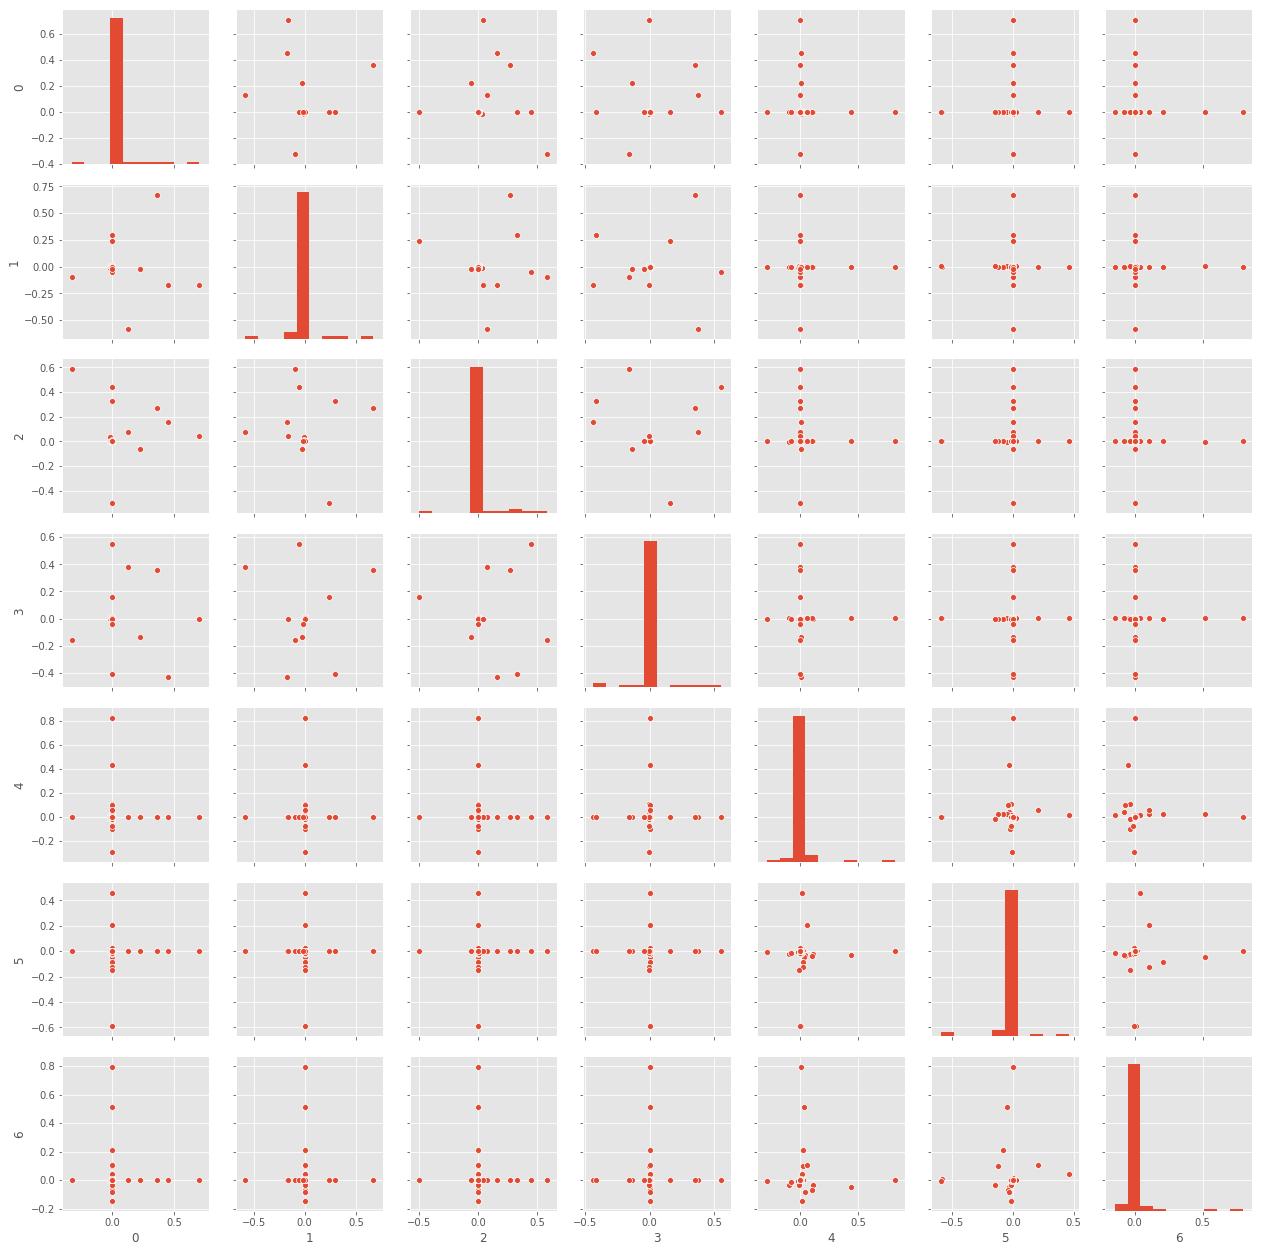

In [592]:
sb.pairplot(PCA_components.iloc[:,:7])



TypeError: 'tuple' object is not callable

In [581]:
#Cluster K-means
model=KMeans(n_clusters=3)
#adapter le modèle de données
model.fit(k)

ValueError: Expected 2D array, got scalar array instead:
array=1.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [559]:
# je recupere les 10 premieres composante 

print(acp.components_[:9])



[[ 1.29816411e-01 -5.79364396e-01  7.32413892e-02  3.76306596e-01
  -1.38181883e-03 -5.19197118e-04  3.48166729e-04 -1.10460275e-03
  -2.51923843e-05 -6.88636829e-05  1.32638222e-03 -1.10032193e-03
  -3.89735526e-04  5.95230411e-04  3.23306021e-04 -1.25013155e-03
   3.72711608e-04  8.26556844e-04 -9.14447006e-05  5.46229800e-05
   6.67224097e-04  6.76780154e-05  3.36592849e-05 -9.98193195e-05
  -1.25831062e-03  1.38362784e-03 -1.65522608e-03 -6.55789114e-04
  -1.66250295e-03  7.32633650e-04 -8.16802178e-04  7.31453005e-04
  -3.35180164e-04 -1.97808737e-03 -9.33886530e-04 -7.55402418e-04
  -1.36974634e-03  5.34596511e-04 -6.55855653e-04 -1.24286529e-03
   4.87765293e-04 -9.15027895e-04 -3.09051952e-05 -2.57507400e-04
  -8.58002166e-04  4.64988974e-04 -3.61129373e-04 -8.13203764e-04
  -1.57784380e-04 -3.75851680e-04 -1.25633218e-03  1.05731133e-03
  -1.66975821e-03  1.29816411e-01 -5.79364396e-01  7.32413892e-02
   3.76306596e-01 -1.15462355e-03 -1.60615484e-03 -1.51843892e-03
  -5.87302

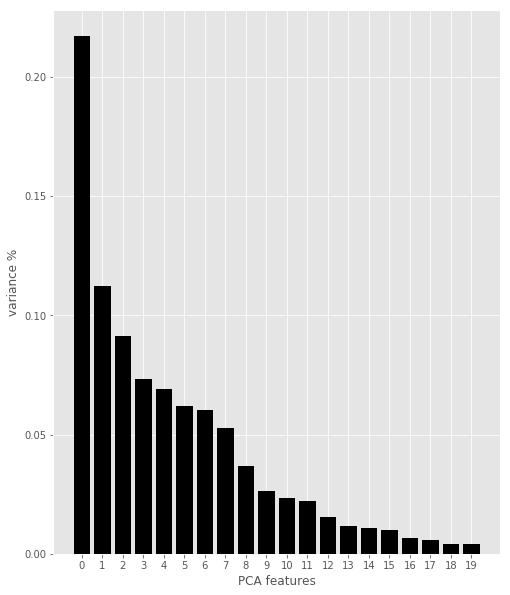

In [600]:

# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(df_merge)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [602]:
PCA_components.shape

(9582, 20)

Text(0,0.5,'PCA 2')

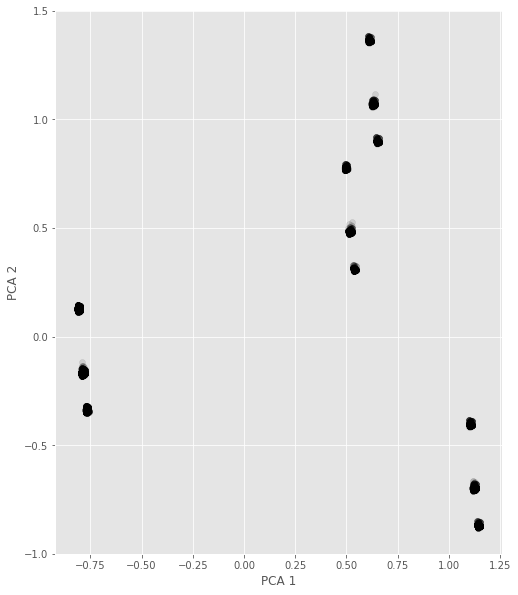

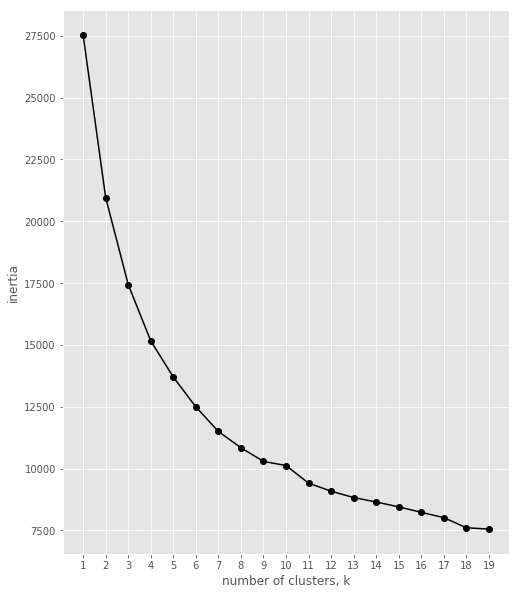

In [608]:
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:15])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

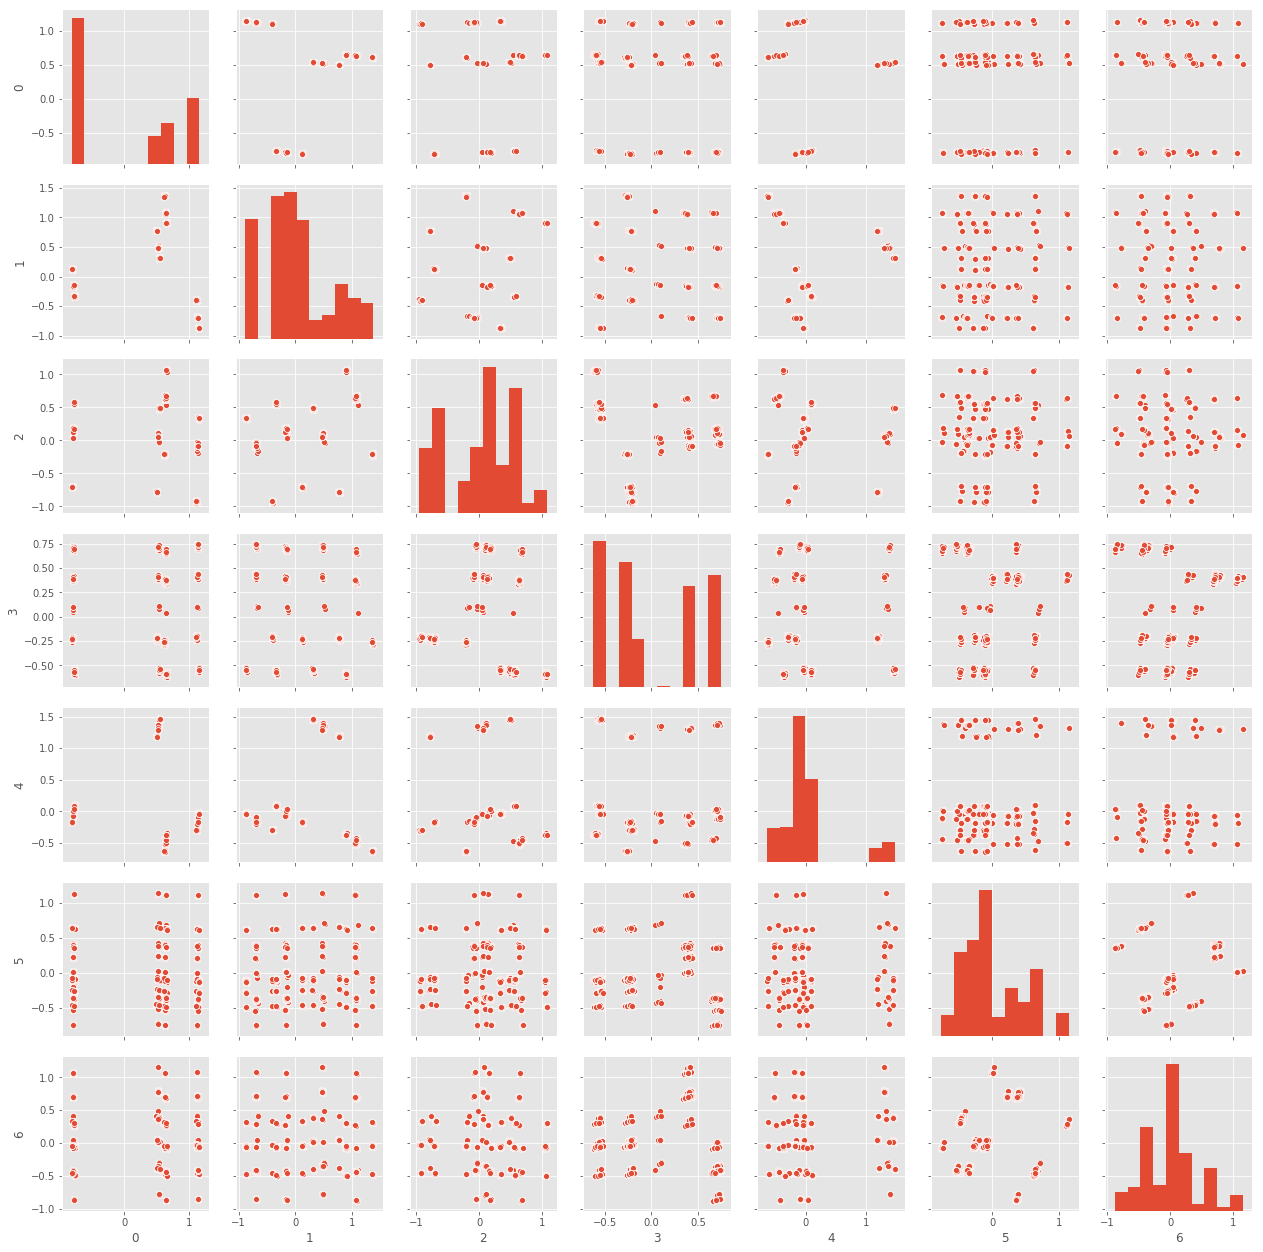

In [609]:
sb.pairplot(PCA_components.iloc[:,:7])


In [612]:
np.shape(PCA_components.iloc[:,:7])

(9582, 7)

In [614]:
plt.text(pca.components_[0, i] + 0.05,
         pca.components_[1, i] + 0.05,
         df.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

IndexError: index 9581 is out of bounds for axis 1 with size 75

[[ 1.09017680e-01  2.71458576e-01  1.21595026e-01 ... -0.00000000e+00
  -0.00000000e+00  0.00000000e+00]
 [-4.86540659e-01 -1.02789994e-01 -1.31955985e-02 ...  1.12361960e-16
  -3.92934154e-18  1.94855067e-17]
 [ 6.15069100e-02  9.39665143e-02 -3.42814926e-02 ...  1.23620476e-16
  -1.90908768e-19 -4.08736197e-17]
 ...
 [ 1.91564944e-03 -1.69164633e-02  7.26558565e-02 ...  2.13970710e-33
   7.48433949e-33 -6.55560611e-34]
 [-2.13440193e-03 -1.95083786e-02  5.13315100e-02 ...  1.31674283e-33
   9.99678773e-33  1.27568551e-33]
 [-1.68401367e-02  1.58738487e-01 -4.06264181e-01 ... -2.63348566e-33
   1.44174245e-32 -5.66971339e-34]]


IndexError: index 74 is out of bounds for axis 0 with size 74

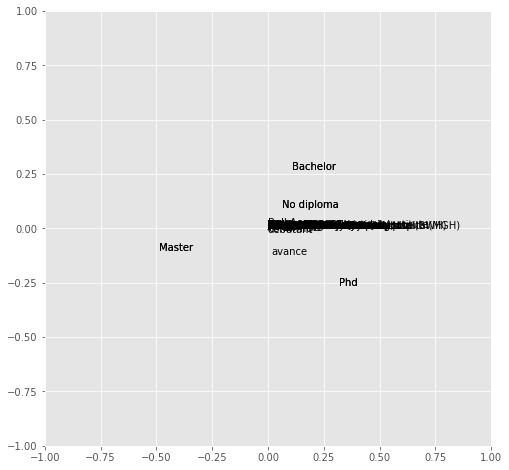

In [631]:
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]
#afficher la matrice des corrélations variables x facteurs
print(corvar)


#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8)) 
axes.set_xlim(-1,1) 
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(p): 
    plt.annotate(X.columns[j],(corvar[j,0],corvar[j,1]))
#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)


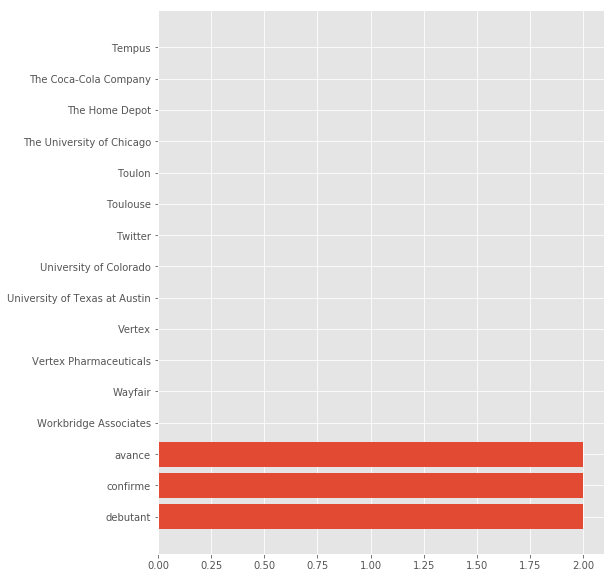

In [632]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
features_names = list(df_merge.columns)
#features_names = ['input1', 'input2', ...] 
svm = svm.SVC(kernel='linear')
svm.fit(X_train, y_train)

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importances(abs(clf.coef_[0]), features_names, top=16)

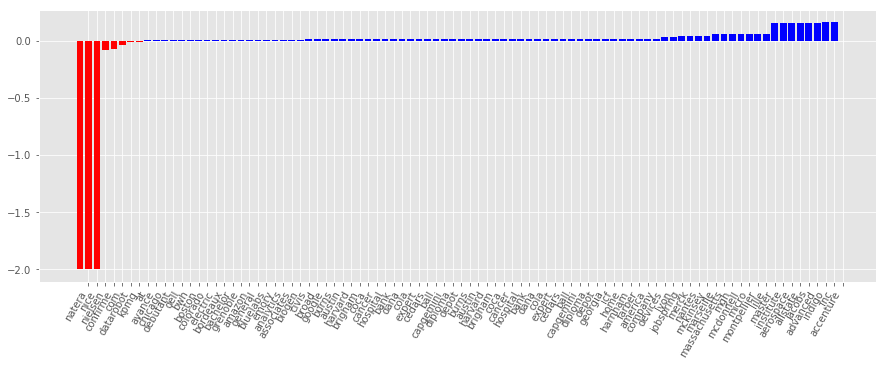

In [530]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

data = df_merge.copy()
def plot_coefficients(classifier, feature_names, top_features=45):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    cv = CountVectorizer()
    cv.fit(X)
    
#print(len(cv.vocabulary_))
#print(cv.get_feature_names())
#X_train = cv.transform(data)

#svm = svm.SVC(kernel='linear')
svm = LinearSVC()
#svm.fit(X_train, target)
svm.fit(X, y)
plot_coefficients(svm, cv.get_feature_names())


In [529]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt



def plot_coefficients(classifier, feature_names, top_features=):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
    print(top_coefficients)
    
    cv = CountVectorizer()
    cv.fit(data)
    #X_train = cv.transform(data)

    svm = LinearSVC()
    svm.fit(X_train, y_train)
    
plot_coefficients(svm, cv.get_feature_names())



AttributeError: module 'sklearn.svm' has no attribute 'coef_'

NameError: name 'selector' is not defined

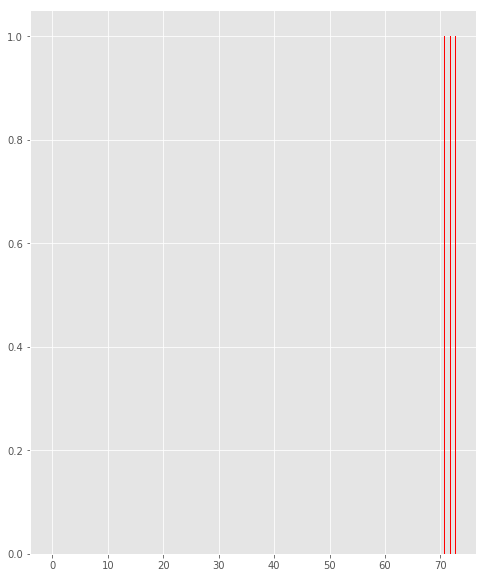

In [527]:
# Compare to the weights of an SVM
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X, y)


X_indices = np.arange(X.shape[-1])


svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight', color='r')

clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(selector.transform(X), y)

svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='b')


plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [615]:
for i in range(0, n_components):
    df['PC' + str(i + 1)] = reduced[:, i]

display(df.head())

NameError: name 'n_components' is not defined

In [170]:
y_app = dtrain.as_matrix()[:,32]
X_app = dtrain.as_matrix()[:,0:32]
#importation de la classe de calcul
from sklearn.svm import SVC
svm = SVC() #instanciation de l’objet
#affichage des paramètres (paramètres par défaut ici c.-à-d. noyau ‘rbf’) #pas de standardisation (scale) des données apparemment
print(svm)
#apprentissage – construction du modèle prédictif
svm.fit(X_app,y_app)
#importation des données test
dtest = pandas.read_table("ionosphere-test.txt",sep="\t",header=0,decimal=".") print(dtest.shape)
y_test = dtest.as_matrix()[:,32]
X_test = dtest.as_matrix()[:,0:32]
#prédiction sur l’échantillon test
y_pred = svm.predict(X_test)
#evaluation : taux d'erreur = 0.07
from sklearn import metrics
err = 1.0 - metrics.accuracy_score(y_test,y_pred)
print(err)

SyntaxError: invalid syntax (<ipython-input-170-bfd50c10f48b>, line 11)

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

### 10) Décrire de façon détaillée les différentes étapes pour mener à bien un projet data complexe.

Dans le cadre d’une campagne de recrutement vous avez reçu un ensemble de cv qui ne sont pas à jour (le poste actuel n’est pas présent). Deux exemple de CV vous sont donnés en pièce jointe (il n'y a pas de mise en page type). Tous les CV sont au format PDF.

On souhaite connaitre le poste actuel de chaque candidat.

-  Quelles sont les différentes étapes nécessaires à la réalisation d'un tel projet?
-  Pour chaque étape, détaillez les taches à accomplir, les méthodes à suivre, les pistes possibles, les points critiques.
-  Justifiez consciencieusement vos choix


In [414]:
from pdftools.pdffile import PDFDocument
 
    
doc = PDFDocument('cv1.pdf')
 
doc.document_version()
 
pages = doc.count_pages()
print(pages)
 


ModuleNotFoundError: No module named 'pdftools'